In [16]:
%matplotlib widget

In [17]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

In [18]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

In [19]:
line = env['cell_u']

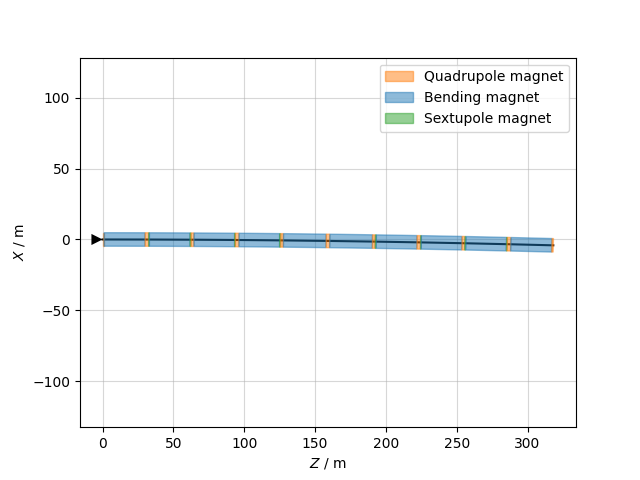

In [20]:
line.survey().plot()

In [21]:
kq_names = ['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6']

In [22]:
line['kqd1'] = -1e-2
line['kqf2'] = 1e-2
line['kqd3'] = -1e-2
line['kqf4'] = 1e-2
line['kqd5'] = -1e-2
line['kqf6'] = 1e-2

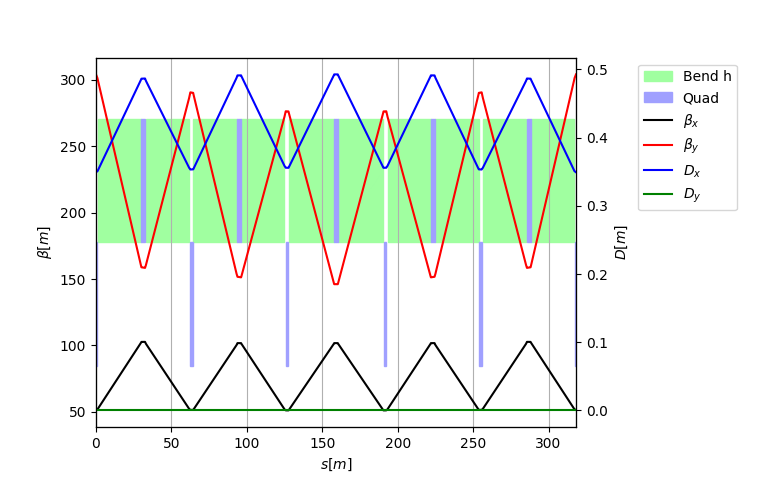

In [23]:
line.twiss4d().plot()

In [24]:
opt_phase = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(kq_names, step=1e-4),
    targets=xt.TargetSet(mux=env['muxu'], muy=env['muyu'], at=xt.END, tol=1e-6)
)
opt_phase.run_jacobian(10)

                                             
Optimize - start penalty: 3.736                             
Matching: model call n. 42 penalty = 6.1519e-07              
Optimize - end penalty:  6.15192e-07                            


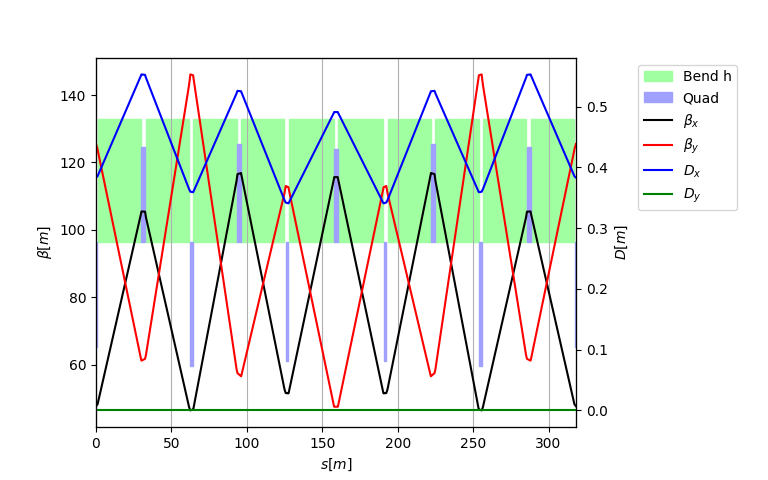

In [25]:
opt_phase.plot()

### Equalize betas and dispersions at quad entries

In [26]:
qf_entry = ['qf2a::0', 'qf4a::0', 'qf6a',    'qf4a::1', 'qf2a::1']
qd_entry = ['qd3a::0', 'qd5a::0', 'qd5a::1', 'qd3a::1', 'qd1a::1']

opt_cell = opt_phase.clone(name='phase + peaks',
    add_targets=[
        xt.Target(lambda tw: np.std(tw.rows[qf_entry].dx),   xt.LessThan(0.001), tag='dx',   tol=1e-3, weight=1000),
        xt.Target(lambda tw: np.std(tw.rows[qd_entry].bety), xt.LessThan(0.5), tag='bety', tol=1e-3, weight=1),
        xt.Target(lambda tw: np.std(tw.rows[qf_entry].betx), xt.LessThan(0.5), tag='betx', tol=1e-3, weight=1),
])

In [27]:
opt_cell.run_simplex(1000)

                                             
Optimize [phase + peaks] - start penalty: 26.55                         
Matching: model call n. 846 penalty = 1.1375e-05              
Optimize [phase + peaks] - end penalty:  1.13753e-05                            


In [28]:
opt_cell.target_status()

Target status:               enalty = 1.1375e-05              
id state tag     tol_met       residue   current_val target_val      description                                 
0  ON    END_mux    True   8.65376e-07      0.706251 0.70625         line=cell_u, ('mux', '_end_point'), val= ...
1  ON    END_muy    True  -7.38303e-07       0.61741 0.617410714286  line=cell_u, ('muy', '_end_point'), val= ...
2  ON    dx         True             0   0.000779832 LessThan(0.001) line=cell_u, callable, val=LessThan(0.00 ...
3  ON    bety       True             0      0.498014 LessThan(0.5)   line=cell_u, callable, val=LessThan(0.5) ...
4  ON    betx       True             0      0.499278 LessThan(0.5)   line=cell_u, callable, val=LessThan(0.5) ...


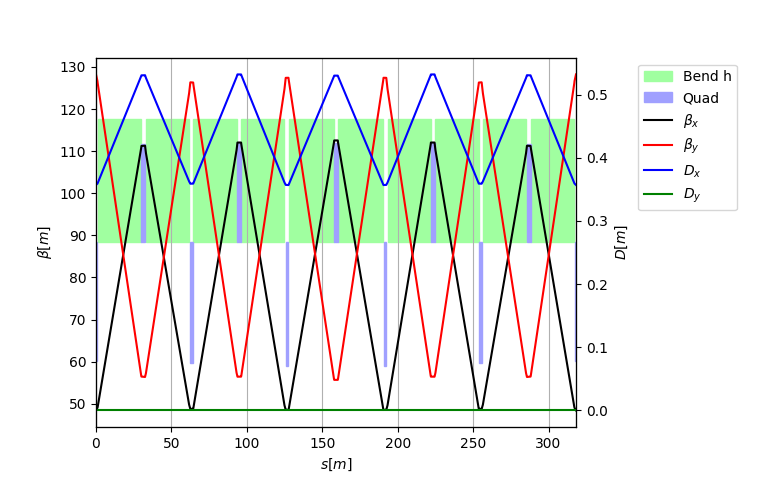

In [29]:
opt_cell.plot()

In [30]:
strengths = opt_cell.get_knob_values()
xt.json.dump(strengths, 'strengths_quads_00_arc_cell.json')